In [1]:
#lets start with some imports

import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop

import operator

import xarray as xr
import netCDF4

import scipy.ndimage as ndimage

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy
import matplotlib.colors as mc
import matplotlib.ticker as mt
import matplotlib.font_manager as fm
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
meta_config = config.get_metadata('cacti_csapr2_ppi')
cmac_config = config.get_cmac_values('cacti_csapr2_ppi')
field_config = config.get_field_names('cacti_csapr2_ppi')


temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

#field_config['reflectivity'] = 'uncorrected_reflectivity_h'
#field_config['phidp'] = 'uncorrected_differential_phase'

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']

In [3]:
verbose = True
sweep = 2

In [12]:
# on bebop
# soundings_directory = '/data/CACTI/sonde/'
# radar_directory = '/data/CACTI/csapr2/'

# on STRATUS
radar_directory = '/lustre/or-hydra/cades-arm/proj-shared/corcsapr2cfrppiM1.a1/201901/'
soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/corsondewnpnM1.b1/'

In [13]:
inf = 'corcsapr2cfrppiM1.a1.20190124.200003.nc'
#inf2 = 'corcsapr2cfrppiM1.a1.20181105.191503.nc'
radar = pyart.io.read(radar_directory + inf)


In [15]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'corsondewnpnM1.b1.20190124.210000.cdf')

In [16]:
print(cmac_config)

{'save_name': 'cacticsapr2cmacppi.c1', 'sonde_name': 'corsondewnpnM1.b1', 'site_alt': 1141, 'ref_offset': 0.0, 'self_const': 60000.0, 'attenuation_a_coef': 0.08, 'c_coef': 0.3, 'd_coef': 1.804, 'beta_coef': 0.64884, 'flip_phidp': True, 'phidp_flipped': ['uncorrected_differential_phase', 'differential_phase'], 'zdr_offset': -3.8, 'offset_zdrs': ['differential_reflectivity_lag_1', 'differential_reflectivity'], 'mbfs': {'multi_trip': {'velocity_texture': [[2.0, 2.1, 130.0, 130.0], 4.0], 'copol_correlation_coeff': [[0.5, 0.7, 1, 1], 0.0], 'normalized_coherent_power': [[0, 0, 0.5, 0.6], 1.0], 'height': [[0, 0, 5000, 8000], 0.0], 'sounding_temperature': [[-100, -100, 100, 100], 0.0], 'signal_to_noise_ratio': [[8, 15, 1000, 1000], 1.0]}, 'rain': {'velocity_texture': [[0, 0, 2.0, 2.1], 1.0], 'copol_correlation_coeff': [[0.97, 0.98, 1, 1], 1.0], 'normalized_coherent_power': [[0.4, 0.5, 1, 1], 1.0], 'height': [[0, 0, 5000, 6000], 0.0], 'sounding_temperature': [[2.0, 5.0, 100, 100], 2.0], 'signal

In [17]:
print(field_config)

{'input_zdr': 'differential_reflectivity', 'reflectivity': 'uncorrected_reflectivity_h', 'velocity': 'mean_doppler_velocity', 'normalized_coherent_power': 'normalized_coherent_power', 'cross_correlation_ratio': 'copol_correlation_coeff', 'input_phidp_field': 'uncorrected_differential_phase', 'input_clutter_corrected_reflectivity': 'reflectivity', 'clutter': 'ground_clutter', 'altitude': 'alt', 'temperature': 'tdry', 'u_wind': 'u_wind', 'v_wind': 'v_wind', 'zdr_field': 'corrected_differential_reflectivity', 'pia_field': 'path_integrated_attenuation', 'phidp_field': 'filtered_corrected_differential_phase', 'refl_field': 'corrected_reflectivity'}


In [18]:
print(meta_config)

{'site_id': 'cor', 'facility_id': 'c1', 'comment': ('This is highly experimental and initial data. There are many', 'known and unknown issues. Please do not use before', 'contacting the Translator responsible scollis@anl.gov'), 'attributions': ('This data is collected by the ARM Climate Research facility.', 'Radar system is operated by the radar engineering team', 'radar@arm.gov and the data is processed by the precipitation', 'radar products team. LP code courtesy of Scott Giangrande BNL.'), 'version': '2.0 lite', 'vap_name': 'cmac', 'known_issues': ('False phidp jumps in insect regions. Still uses old', 'Giangrande code.', 'Issues with some snow below melting layer.'), 'developers': 'Robert Jackson, ANL. Zachary Sherman, ANL.', 'translator': 'Scott Collis, ANL.', 'mentors': ('Nitin Bharadwaj, PNNL. Bradley Isom, PNNL.', 'Joseph Hardin, PNNL. Iosif Lindenmaier, PNNL.')}


In [19]:
if cmac_config['flip_phidp']:
    for fld in cmac_config['phidp_flipped']:
        radar.fields[fld]['data'] = radar.fields[fld]['data']*-1.0
        

In [20]:
if 'zdr_offset' in cmac_config.keys():
    if 'offset_zdrs' in cmac_config.keys():
        for fld in cmac_config['offset_zdrs']:
            radar.fields[fld]['data'] += cmac_config['zdr_offset']
    else:
        radar.fields[field_config['input_zdr']]['data'] += cmac_config['zdr_offset']


In [21]:
if 'gen_clutter_from_refl' not in cmac_config.keys():
    cmac_config['gen_clutter_from_refl'] = False

if cmac_config['gen_clutter_from_refl']:
    new_clutter_field = cmac_processing.gen_clutter_field_from_refl(radar, 
                                                                    field_config['input_clutter_corrected_reflectivity'],
                                                                    field_config['reflectivity'],
                                                                    diff_dbz=cmac_config['gen_clutter_from_refl_diff'], 
                                                                    max_h=cmac_config['gen_clutter_from_refl_alt'])
    radar.add_field(field_config['clutter'], new_clutter_field, replace_existing=True)
                                 
                                 

In [24]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('America/Cordoba')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = '%.1f' % radar.fixed_angle['data'][sweep] + ' Degree sweep ' +local_time.strftime('%A %B %d at %I:%M %p GMT%Z')
print(fancy_date_string)

2.6 Degree sweep Thursday January 24 at 05:00 PM GMT-03


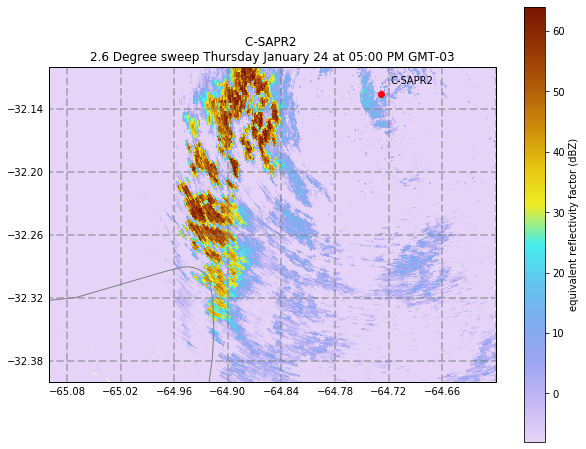

In [25]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'uncorrected_reflectivity_h', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

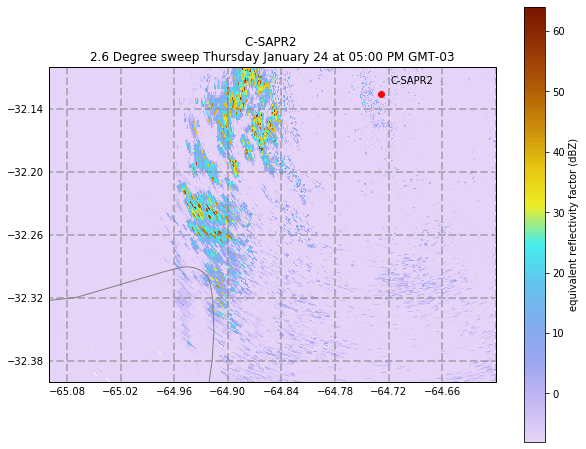

In [26]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

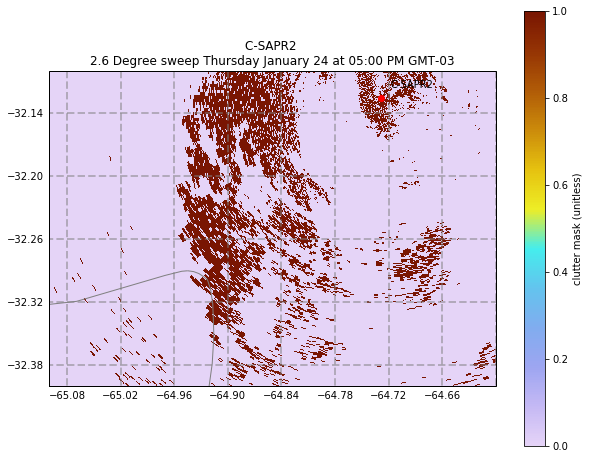

In [27]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'ground_clutter', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [28]:
radar.fields.keys()


dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_spectral_width_v', 'unthresholded_power_copolar_h', 'unthresh

In [29]:
radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
print('##', str(radar_start_date))

## 2019-01-24 20:00:03


In [30]:
if 'clutter_mask_z_for_texture' not in cmac_config.keys():
        cmac_config['clutter_mask_z_for_texture'] = False

if cmac_config['clutter_mask_z_for_texture']:
    masked_vr = copy.deepcopy(radar.fields[vel_field])
    masked_vr['data'] = np.ma.masked_where(radar.fields['ground_clutter']['data'] == 1, masked_vr['data'])
    masked_vr['data'][radar.fields['ground_clutter']['data'] == 1] = np.nan
    radar.add_field('clutter_masked_velocity', masked_vr, replace_existing=True)

    texture = cmac_processing.get_texture(radar, 'clutter_masked_velocity')
    texture['data'][np.isnan(texture['data'])] = 0.0
else:
    texture = cmac_processing.get_texture(radar, vel_field)

In [31]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                        ncf_sounding.variables[alt_field][:], 
                                                        radar)


snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

In [32]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)


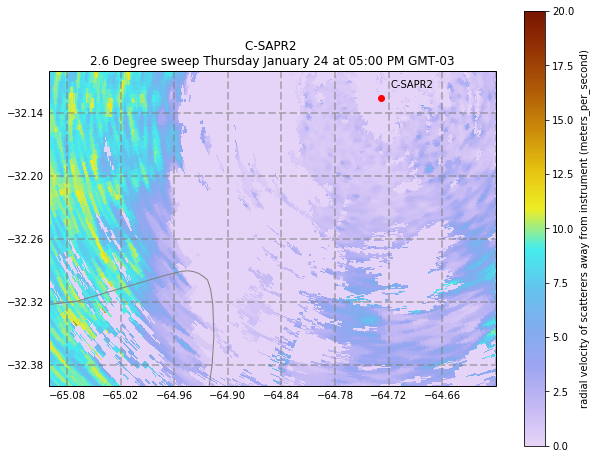

In [33]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'velocity_texture', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=20, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


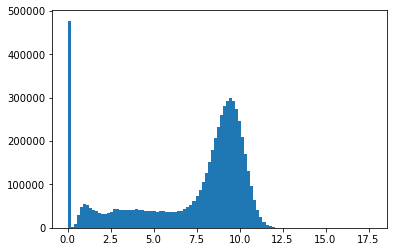

In [34]:
hh = plt.hist(radar.fields['velocity_texture']['data'].flatten(), bins=100)

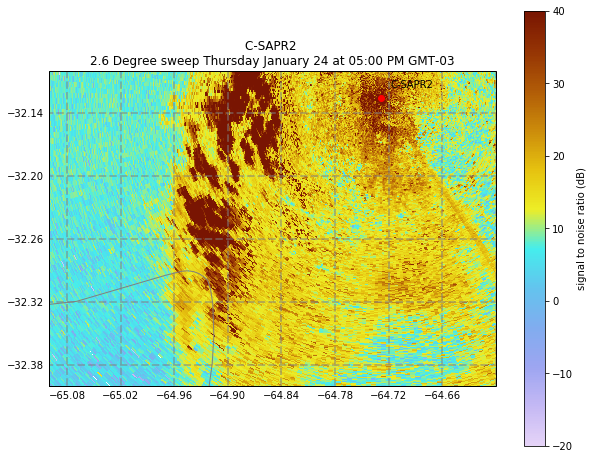

In [35]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'signal_to_noise_ratio', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-20, vmax=40, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

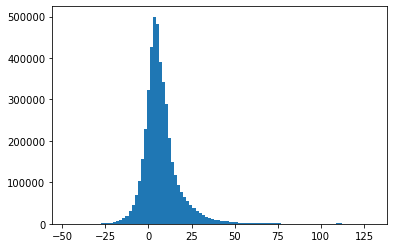

In [36]:
hh = plt.hist(radar.fields['signal_to_noise_ratio']['data'].flatten(), bins=100)

In [37]:
rhv_field = field_config['cross_correlation_ratio']
ncp_field = field_config['normalized_coherent_power']

if 'mbfs' not in cmac_config:
    cmac_config['mbfs'] = None

if 'hard_const' not in cmac_config:
    cmac_config['hard_const'] = None


my_fuzz, _ = cmac_processing.do_my_fuzz(radar, rhv_field, ncp_field, tex_start=4.,
                        tex_end=5., 
                        custom_mbfs=cmac_config['mbfs'],
                        custom_hard_constraints=cmac_config['hard_const'],
                        verbose=True)

radar.add_field('gate_id', my_fuzz,
                replace_existing=True)

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5401, 5401, 5401]), array([ 0,  1,  2, ..., 49, 50, 51]))
##    Doing hard constraining multi_trip
##     (array([1440, 1440, 1440, ..., 5401, 5401, 5401]), array([ 987,  988,  989, ..., 1097, 1098, 1099]))
##    Doing hard constraining melting
##     (array([ 720,  720,  720, ..., 5401, 5401, 5401]), array([1046, 1047, 1048, ..., 1097, 1098, 1099]))
##    Doing hard constraining rain
##     (array([ 721,  721,  721, ..., 5401, 5401, 5401]), array([1069, 1070, 1071, ...,  513,  514,  515]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5401, 5401, 5401]), array([ 244,  245,  246, ..., 1097, 1098, 1099]))
2


In [38]:
if 'ground_clutter' in radar.fields.keys():
    # Adding fifth gate id, clutter.
    clutter_data = radar.fields['ground_clutter']['data']
    gate_data = radar.fields['gate_id']['data']
    radar.fields['gate_id']['data'][clutter_data == 1] = 5
    notes = radar.fields['gate_id']['notes']
    radar.fields['gate_id']['notes'] = notes + ',5:clutter'
    radar.fields['gate_id']['valid_max'] = 5
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

if verbose:
    print('##    gate_id')

##    gate_id


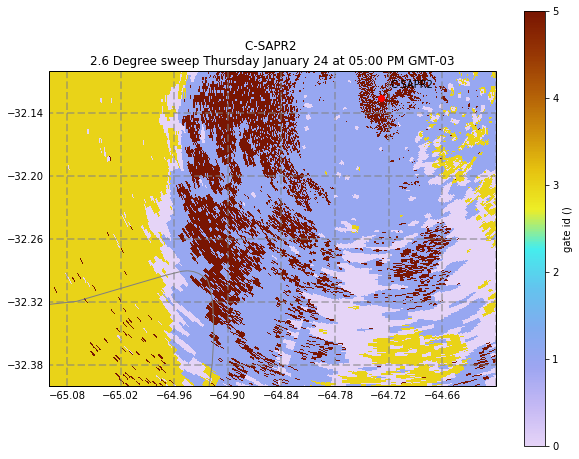

In [39]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

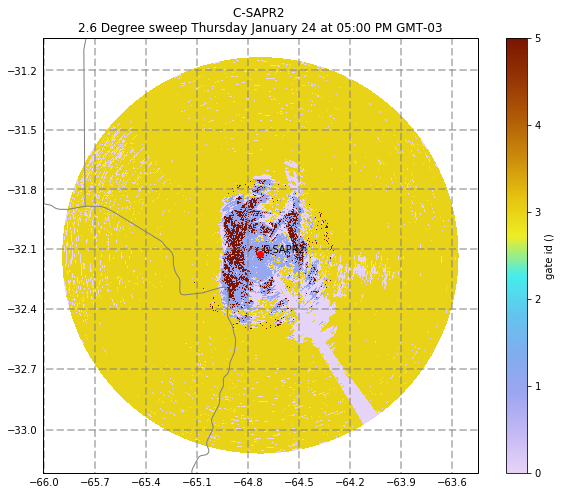

In [40]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

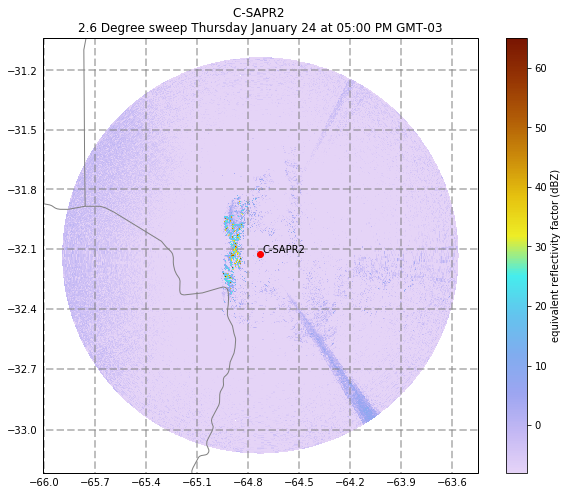

In [41]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=65)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [42]:
print(radar.fields['gate_id']['notes'])

0:multi_trip,1:rain,2:snow,3:no_scatter,4:melting,5:clutter


In [43]:
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})


In [44]:
cmac_gates = pyart.correct.GateFilter(radar)
cmac_gates.exclude_all()
cmac_gates.include_equal('gate_id', cat_dict['rain'])
cmac_gates.include_equal('gate_id', cat_dict['melting'])
cmac_gates.include_equal('gate_id', cat_dict['snow'])


In [45]:
radar.gate_altitude['data']

masked_array(
  data=[[ 1141.,  1142.,  1143., ...,  2943.,  2945.,  2947.],
        [ 1141.,  1142.,  1143., ...,  2943.,  2945.,  2947.],
        [ 1141.,  1142.,  1143., ...,  2943.,  2945.,  2947.],
        ...,
        [ 1141.,  1194.,  1249., ..., 60896., 60950., 61006.],
        [ 1141.,  1194.,  1249., ..., 60896., 60950., 61006.],
        [ 1141.,  1194.,  1249., ..., 60896., 60950., 61006.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [46]:
#Bug: need to fix
radar.gate_altitude['data'] = radar.gate_altitude['data'].data

# Create a simulated velocity field from the sonde object.
u_field = field_config['u_wind']
v_field = field_config['v_wind']
u_wind = ncf_sounding.variables[u_field][:]
v_wind = ncf_sounding.variables[v_field][:]
alt_field = field_config['altitude']
sonde_alt = ncf_sounding.variables[alt_field][:]
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
    sonde_alt, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)


In [47]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
    keep_original=False, gatefilter=cmac_gates, centered=True)

radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

print('##    corrected_velocity')
print('##    simulated_velocity')

fzl = cmac_processing.get_melt(radar)


##    corrected_velocity
##    simulated_velocity
5448.0


In [52]:
radar.fields.keys()

dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_spectral_width_v', 'unthresholded_power_copolar_h', 'unthresh

In [59]:

# Calculating differential phase fields.
phidp, kdp = pyart.correct.phase_proc_lp_gf(
    radar, gatefilter=cmac_gates, offset=ref_offset, debug=True,
    nowrap=50, fzl=fzl, self_const=self_const, phidp_field=field_config['phidp_field'])
phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
    copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
    cmac_gates)

radar.add_field('corrected_differential_phase', phidp,
                replace_existing=True)
radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                replace_existing=True)
radar.add_field('corrected_specific_diff_phase', kdp,
                replace_existing=True)
radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                replace_existing=True)

print('##    corrected_specific_diff_phase')
print('##    filtered_corrected_specific_diff_phase')
print('##    corrected_differential_phase')
print('##    filtered_corrected_differential_phase')


Unfolding


KeyError: 'filtered_corrected_differential_phase'

In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_differential_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=50, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
# Calculating attenuation by using pyart.
refl_field = field_config['reflectivity']
attenuation_a_coef = cmac_config['attenuation_a_coef']
c_coef = cmac_config['c_coef']
d_coef = cmac_config['d_coef']
beta_coef = cmac_config['beta_coef']
zdr_field = field_config['differential_reflectivity']

In [ ]:
radar.fields['corrected_differential_reflectivity'] = copy.deepcopy(
    radar.fields[zdr_field])
radar.fields['corrected_reflectivity'] = copy.deepcopy(
    radar.fields[refl_field])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_where(
    cmac_gates.gate_excluded,
    radar.fields['corrected_reflectivity']['data'])

# Get specific differential attenuation.
# Need height over 0C isobar.
iso0 = np.ma.mean(radar.fields['height']['data'][
    np.where(np.abs(radar.fields['sounding_temperature']['data']) < 0.1)])
radar.fields['height_over_iso0'] = copy.deepcopy(radar.fields['height'])
radar.fields['height_over_iso0']['data'] -= iso0

In [ ]:
(spec_at, pia_dict, cor_z, spec_diff_at,
 pida_dict, cor_zdr) = pyart.correct.calculate_attenuation_zphi(
     radar, temp_field='sounding_temperature',
     iso0_field='height_over_iso0',
     zdr_field='corrected_differential_reflectivity',
     pia_field='path_integrated_attenuation',
     refl_field=field_config['reflectivity'], 
     c=c_coef, d=d_coef,
     a_coef=attenuation_a_coef, beta=beta_coef,
     phidp_field='filtered_corrected_differential_phase')
cor_zdr['data'] += cmac_config['zdr_offset']
radar.add_field('specific_attenuation', spec_at, replace_existing=True)
radar.add_field('path_integrated_attenuation', pia_dict,
                replace_existing=True)
radar.add_field('corrected_reflectivity', cor_z, replace_existing=True)
radar.add_field('specific_differential_attenuation', spec_diff_at,
                replace_existing=True)
radar.add_field('path_integrated_differential_attenuation', pida_dict,
                replace_existing=True)
radar.add_field('corrected_differential_reflectivity', cor_zdr,
                replace_existing=True)


In [ ]:
print(attenuation_a_coef, beta_coef,c_coef, d_coef)

In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_specific_diff_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=6, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'specific_attenuation', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=0.5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
# https://journals.ametsoc.org/doi/pdf/10.1175/JAMC-D-13-0321.1

In [ ]:
# Calculating rain rate.
R = 294.* (radar.fields['specific_attenuation']['data']) ** 0.89
rainrate = copy.deepcopy(radar.fields['specific_attenuation'])
rainrate['data'] = R
rainrate['valid_min'] = 0.0
rainrate['valid_max'] = 400.0
rainrate['standard_name'] = 'rainfall_rate'
rainrate['long_name'] = 'rainfall_rate'
rainrate['least_significant_digit'] = 1
rainrate['units'] = 'mm/hr'
radar.fields.update({'rain_rate_A': rainrate})

# This needs to be updated to a gatefilter.
mask = radar.fields['reflectivity']['data'].mask

radar.fields['rain_rate_A']['data'][np.where(mask)] = 0.0
radar.fields['rain_rate_A'].update({
    'comment': ('Rain rate calculated from specific_attenuation,',
                ' R=51.3*specific_attenuation**0.81, note R=0.0 where',
                ' norm coherent power < 0.4 or rhohv < 0.8')})

if verbose:
    print('## Rainfall rate as a function of A ##')

print('##')
print('## All CMAC fields have been added to the radar object.')
print('##')

In [ ]:
clutter = pyart.filters.GateFilter(radar)
clutter.exclude_equal('gate_id', cat_dict['clutter'])


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0.1, vmax=80, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=10, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1, gatefilter=cmac_gates)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'path_integrated_differential_attenuation', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-1, vmax=7, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=clutter)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=100 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
# plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                   barcol1 = 'white', barcol2='dimgrey'):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(cartopy.crs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = cartopy.crs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = barcol1
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == barcol1:
            barcol = barcol2
        else:
            barcol = barcol1
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=20)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby, str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=20)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    #ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
    #       verticalalignment='bottom', color=col)



In [ ]:
cat_dict = {}
print('##')
print('## Keys for each gate id are as follows:')
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print('##   ', str(pair_str))
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})
sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))
cat_colors = {'rain': 'green',
              'multi_trip': 'red',
              'no_scatter': 'gray',
              'snow': 'cyan',
              'melting': 'yellow'}
lab_colors = ['red', 'cyan', 'grey', 'green', 'yellow']

if 'clutter' in radar.fields.keys():
    cat_colors['clutter'] = 'black'
    lab_colors = np.append(lab_colors, 'black')
lab_colors = [cat_colors[kitty[0]] for kitty in sorted_cats]

cmap = mc.ListedColormap(lab_colors)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure( figsize=[15, 8])


display.plot_ppi_map('gate_id', sweep=sweep,
                     cmap=cmap,
                     vmin=0, vmax=5, 
                     projection=cartopy.crs.PlateCarree())

ax = plt.gca()
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=.5, color='black', 
                          alpha=0.3, linestyle='--')

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)


scale_bar_left(ax, bars=4,length=100, location=(0.25, 0.98), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


cbax = ax
if 'clutter' in radar.fields.keys():
    tick_locs = np.linspace(
        0, len(sorted_cats) - 2, len(sorted_cats)) + 0.5
else:
    tick_locs = np.linspace(
        0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
display.cbs[-1].locator = mt.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = mt.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()

gl.xlabels_top = False
gl.ylabels_right = False




In [ ]:
cat_dict = {}
print('##')
print('## Keys for each gate id are as follows:')
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print('##   ', str(pair_str))
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})
sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))
cat_colors = {'rain': 'green',
              'multi_trip': 'red',
              'no_scatter': 'gray',
              'snow': 'cyan',
              'melting': 'yellow'}
lab_colors = ['red', 'cyan', 'grey', 'green', 'yellow']

if 'clutter' in radar.fields.keys():
    cat_colors['clutter'] = 'black'
    lab_colors = np.append(lab_colors, 'black')
lab_colors = [cat_colors[kitty[0]] for kitty in sorted_cats]

cmap = mc.ListedColormap(lab_colors)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure( figsize=[15, 8])


display.plot_ppi_map('gate_id', sweep=sweep,
                     cmap=cmap,
                     vmin=0, vmax=5, 
                     projection=cartopy.crs.PlateCarree(), 
                     min_lon=-65.1, min_lat=-32.4, 
                     max_lon=-64.6, max_lat=-32.1)

ax = plt.gca()

gl = display.ax.gridlines(draw_labels=True,
                          linewidth=.5, color='black', 
                          alpha=0.3, linestyle='--')

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)


display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


cbax = ax
if 'clutter' in radar.fields.keys():
    tick_locs = np.linspace(
        0, len(sorted_cats) - 2, len(sorted_cats)) + 0.5
else:
    tick_locs = np.linspace(
        0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
display.cbs[-1].locator = mt.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = mt.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()

gl.xlabels_top = False
gl.ylabels_right = False




In [ ]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=cmac_gates)

ax = plt.gca()

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
cmac_extended = pyart.correct.despeckle.despeckle_field(radar, 'corrected_reflectivity', gatefilter=cmac_gates)

In [ ]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=cmac_extended)

ax = plt.gca()

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='black', barcol1='black',
              barcol2='blue')


# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [ ]:
low_z = cmac_extended.copy()
low_z.exclude_below('reflectivity', -5 )
low_z_desp = pyart.correct.despeckle.despeckle_field(radar, 'corrected_differential_reflectivity',
                                                     gatefilter=low_z)

In [ ]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-1, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_specific_diff_phase', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-.5, vmax=7, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=12, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
correct_sweep = radar.get_slice(sweep)
refl_correct_sweep = radar.fields['corrected_reflectivity']['data'][correct_sweep]
correct_lats = radar.gate_latitude['data'][correct_sweep]
correct_lons = radar.gate_longitude['data'][correct_sweep]

refl_correct_sweep_ma = np.ma.masked_where(low_z_desp.gate_excluded[correct_sweep], refl_correct_sweep)
#refl_correct_sweep_ma[low_z_desp.gate_excluded[correct_sweep]] = np.nan

refl_smooth = np.ma.masked_where(low_z_desp.gate_excluded[correct_sweep],
                                 ndimage.gaussian_filter(refl_correct_sweep, sigma=1., order=0))

In [ ]:
az_210 = np.where(abs(radar.azimuth['data'] - 210.0) < .5)
first_ray = az_210[0][0]
drdi = radar.range['data'][1] - radar.range['data'][0]
gate_at_30km = 30000./drdi

latline = radar.gate_latitude['data'][int(first_ray), int(gate_at_30km)]
lonline = radar.gate_longitude['data'][int(first_ray), int(gate_at_30km)]


In [ ]:
font = fm.FontProperties(weight='bold', size=16)

#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap='viridis',
    vmin=0, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

#ndimage.gaussian_filter(hght_500, sigma=5, order=0)

CS = ax.contour(correct_lons, correct_lats, refl_smooth ,
                levels = [15., 30., 45.],
                transform = cartopy.crs.PlateCarree(), colors=['purple', 'pink', 'yellow'],
                linewidths=3)

labs = ax.clabel(CS, inline=1, fontsize=15,fmt='%1.0f' )
for lab in labs:
    lab.set_font_properties(font)

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.plot([lon_0*-1, lonline], [lat_0, latline], 'r--', transform = cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='lightgrey', barcol1='black',
              barcol2='red')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [ ]:
font = fm.FontProperties(weight='bold', size=16)

#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
    vmin=0, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

#ndimage.gaussian_filter(hght_500, sigma=5, order=0)

CS = ax.contour(correct_lons, correct_lats, refl_smooth ,
                levels = [15., 30., 45.],
                transform = cartopy.crs.PlateCarree(), colors=['purple', 'pink', 'yellow'],
                linewidths=3)

labs = ax.clabel(CS, inline=1, fontsize=15,fmt='%1.0f' )
for lab in labs:
    lab.set_font_properties(font)

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='lightgrey', barcol1='black',
              barcol2='red')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
